# Logistic Regression using Tensorflow
Applico la regressione logistica a un dataset semplice, ha una struttura tabellare. Sulla base di vari attributi di persone si cerca di predire se il reddito supero 50k dollari.

In [30]:
from types import SimpleNamespace


from data import get_adult

import tensorflow as tf
import numpy as np 
import random
import matplotlib.pyplot as plt


In [36]:
class LogisticRegression():
    def __init__(self,
                 d,  # Dimension of the input vector
                 lr,  # learning rate
                 momentum,  # momentum
                 nesterov,  # NAG (if True) or classic momentum (False)
                 batch_size,  # Batch size
                 num_epochs,  # number of cycles through the whole training set
                 seed,  # !=0 to reproduce from run to run
                 ):
        # lock the seed for reproducibility
        tf.random.set_seed(seed)
        self.d = d
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        # Declare parameters as tensorflow variables
        self.w = tf.Variable(tf.random.normal(shape=[d, 1]), name='w')
        self.b = tf.Variable(tf.random.normal(shape=[1, 1]), name='b')
        self.optimizer = tf.optimizers.SGD(
            learning_rate=lr,
            momentum=momentum,
            nesterov=nesterov)
        self.losses = []
        self.accs = []

    def _compute_logits(self, X):
        f = tf.matmul(X, self.w) + self.b 
        return f
    
    def _step(self, X, y):
        with tf.GradientTape() as tape:
            f = self._compute_logits(X)
            loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=f, labels=y)  # calcolo della loss passando i logits e labels
            loss = tf.reduce_mean(loss)  # media su tutti gli elementi del mini batch
        gradients = tape.gradient(loss, [self.w, self.b])  # recupero il gradiente
        self.optimizer.apply_gradients(zip(gradients, [self.w, self.b]))  # applico gradiente
        prediction = tf.round(tf.sigmoid(f))  # 1 se > 0.5, altrimenti 0
        correct = tf.cast(tf.equal(prediction, y), dtype=tf.float32) 
        accuracy = tf.reduce_mean(correct)
        return loss, accuracy
    
    def _metrics(self, X, y):  # serve per vedere l'andamento dell'ottimizzazione con Tensorboard
        f = self._compute_logits(X)
        loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=f, labels=y)
        loss = tf.reduce_mean(loss)
        prediction = tf.round(tf.sigmoid(f))
        correct = tf.cast(tf.equal(prediction, y), dtype=tf.float32)
        accuracy = tf.reduce_mean(correct)
        return loss, accuracy
    
    def fit(self, X_train, y_train, X_test, y_test): 
        n, d = X_train.shape
        assert d == self.d  # controllo che le dimensioni siano corrette a runtime
        random.seed(1234)
        
        # TensorBoard writers per monitorare loss e accuracy
        # Commentati per disabilitare TensorBoard
        # train_summary_writer = tf.summary.create_file_writer('tensorboard/log_regr/train')
        # test_summary_writer = tf.summary.create_file_writer('tensorboard/log_regr/test')
        
        for epoch in range(self.num_epochs): 
            idx = list(range(n))  # lista di indici, n = dimensione training set
            random.shuffle(idx)  # mescolo la lista con metodo random shuffle (visto a lezione)
            losses, accs = [], []  # per salvare loss e accuracy dei mini batch
            num_batches = n // self.batch_size 
            for b in range(num_batches):
                mb_idx = np.array(idx[b * self.batch_size:(b + 1) * self.batch_size])  # prendo un sottoinsieme di indici per il mini batch
                X_mb = X_train[mb_idx]  # estraggo input
                y_mb = np.matrix(y_train[mb_idx]).T  # estraggo label
                loss, acc = self._step(X_mb, y_mb)  # eseguo uno step di ottimizzazione
                losses.append(loss)
                accs.append(acc)
            print(f"Epoch: {epoch + 1:4d}", end=" ")
            print(f"Loss: {np.array(losses).mean():.5f}", end=" ")
            print(f"Acc: {100 * np.array(accs).mean():.2f}%")
            self.losses.append(np.array(losses).mean())
            self.accs.append(100 * np.array(accs).mean())
            
            # Scrittura dei risultati su TensorBoard
            # Commentati per disabilitare TensorBoard
            # with train_summary_writer.as_default(): 
            #     loss, acc = self._metrics(X_train, np.matrix(y_train).T)
            #     tf.summary.scalar('loss', loss, step=epoch)
            #     tf.summary.scalar('accuracy', acc, step=epoch)
            # with test_summary_writer.as_default():
            #     loss, acc = self._metrics(X_test, np.matrix(y_test).T)
            #     tf.summary.scalar('loss', loss, step=epoch)
            #     tf.summary.scalar('accuracy', acc, step=epoch)
                
    def predict(self, X_np):  # fa inferenza sul test set calcolando i logits
        n, d = X_np.shape
        assert d == self.d
        pred = self._compute_logits(X_np)
        return (pred > 0).numpy().flatten()
    

# Definisci le tue opzioni direttamente qui
opts = SimpleNamespace(
    datafile='adult.csv',
    lr=0.01,
    momentum=0.95,
    nesterov=False,
    batch_size=1024,
    num_epochs=32,
    seed=1234
)

# Carica il dataset
X_train, y_train, X_test, y_test = get_adult(opts.datafile)

# Costruisci il modello recuperando parametri da opts
clf = LogisticRegression(
    d=X_train.shape[1],
    lr=opts.lr,
    momentum=opts.momentum,
    nesterov=opts.nesterov,
    batch_size=opts.batch_size,
    num_epochs=opts.num_epochs,
    seed=opts.seed
)

# Esegui il fit e la previsione
clf.fit(X_train, y_train, X_test, y_test)
pred = clf.predict(X_test)
print(f'Test set accuracy: {np.mean(pred == y_test) * 100:.2f}%')



Epoch:    1 Loss: 0.91138 Acc: 63.44%
Epoch:    2 Loss: 0.49737 Acc: 78.04%
Epoch:    3 Loss: 0.44679 Acc: 80.56%
Epoch:    4 Loss: 0.43260 Acc: 81.08%
Epoch:    5 Loss: 0.41908 Acc: 81.36%
Epoch:    6 Loss: 0.40935 Acc: 81.70%
Epoch:    7 Loss: 0.40047 Acc: 81.98%
Epoch:    8 Loss: 0.39223 Acc: 82.24%
Epoch:    9 Loss: 0.38663 Acc: 82.35%
Epoch:   10 Loss: 0.38094 Acc: 82.57%
Epoch:   11 Loss: 0.37505 Acc: 82.81%
Epoch:   12 Loss: 0.37152 Acc: 82.94%
Epoch:   13 Loss: 0.36769 Acc: 83.07%
Epoch:   14 Loss: 0.36421 Acc: 83.23%
Epoch:   15 Loss: 0.36136 Acc: 83.36%
Epoch:   16 Loss: 0.35958 Acc: 83.47%
Epoch:   17 Loss: 0.35676 Acc: 83.56%
Epoch:   18 Loss: 0.35473 Acc: 83.67%
Epoch:   19 Loss: 0.35246 Acc: 83.76%
Epoch:   20 Loss: 0.35139 Acc: 83.82%
Epoch:   21 Loss: 0.34910 Acc: 83.87%
Epoch:   22 Loss: 0.34832 Acc: 83.94%
Epoch:   23 Loss: 0.34700 Acc: 84.04%
Epoch:   24 Loss: 0.34564 Acc: 84.08%
Epoch:   25 Loss: 0.34454 Acc: 84.15%
Epoch:   26 Loss: 0.34360 Acc: 84.22%
Epoch:   27 

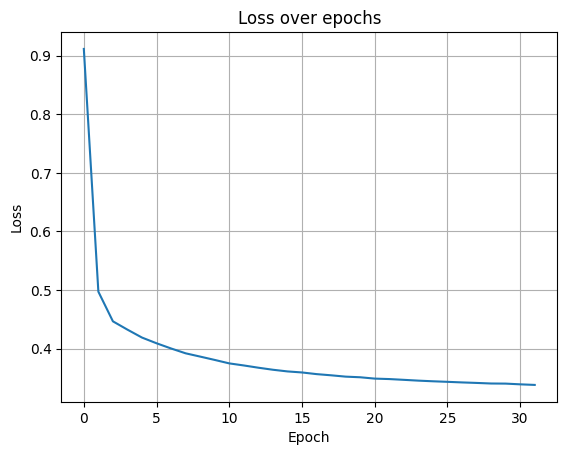

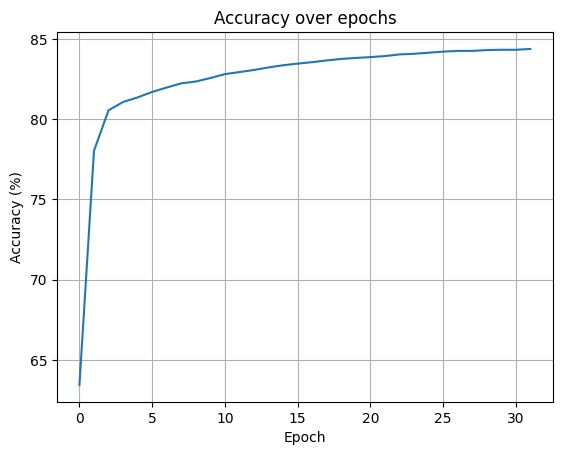

In [39]:
# Grafico della Loss
plt.figure()  # Crea una nuova figura
x = [i for i in range(opts.num_epochs)]
y = clf.losses  # La lista delle perdite medie
plt.plot(x, y)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.show()  # Mostra il grafico della Loss

# Grafico dell'Accuracy
plt.figure()  # Crea una nuova figura
y = clf.accs  # La lista delle accuratezze medie
plt.plot(x, y)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over epochs')
plt.show()  # Mostra il grafico dell'Accuracy
